<a href="https://colab.research.google.com/github/kimheeseo/LSCNS/blob/main/OOK_transmission_with_advanced_EDFA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simulate a OOK transmission system with an advanced EDFA model**

출처: https://github.com/edsonportosilva/OptiCommPy/blob/main/examples/OOK_transmission_with_advanced_EDFA_model.ipynb

시뮬레이션 라이브러리 OptiCommPy 자동 다운로드 및 설치 스크립트
- Script for automatically downloading and installing the OptiCommPy simulation library

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.11.0-py3-none-any.whl size=109779 sha256=c1b7263196edab9f3b99adaccca45da0748738a429b9abfb755e765e6c0c3c78
  Stored in directory: /tmp/pip-ephem-wheel-cache-zwm6cqxj/wheels/e7/51/a4/9a2d1dac30da20ac41d7157db2114765e1712b94ccc8944634
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.11.0
    Uninstalling OptiCommPy-0.11.0:
      Successfully uninstalled OptiCommPy-0.11.0


**OptiCommPy 기반 광통신 시뮬레이션을 위한 라이브러리들을 불러오는 준비 코드**

In [2]:
import numpy as np
from optic.models.devices import mzm, photodiode, voa
from optic.dsp.core import upsample, signalPower, pulseShape, anorm, pnorm
from optic.comm.modulation import modulateGray
from optic.comm.sources import bitSource
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from scipy.constants import c
from optic.models.amplification import edfaSM,OSA

import os.path as path

/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

Notebook 안에서 HTML 형식의 출력을 가능하게 하는 함수

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

In [5]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
figsize(10,3)

**intensity modulation (IM) with On-Off Keying(OOK)**

In [7]:
# simulation parameters
SpS = 8      # samples per symbol
M = 2        # order of the modulation format
Rs = 10e9    # Symbol rate (for OOK case Rs = Rb)
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period
# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W, 송신 광세기의 기준: 1mW

# Bit source parameters
paramBits = parameters()
paramBits.nBits = 100000  # number of bits to be generated
paramBits.mode = 'prbs'   # mode of the bit source
paramBits.order = 23      # order of the PRBS
paramBits.seed = 12335    # seed for the random number generator

In [8]:
# pulse shaping parameters
paramPulse = parameters()
paramPulse.pulseType = 'nrz'  # pulse shape type
paramPulse.SpS = SpS     # samples per symbol

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# generate pseudo-random bit sequence
bitsTx = bitSource(paramBits)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
pulse = pulseShape(paramPulse)
sigTx = firFilter(pulse, symbolsUp)

sigTx = anorm(sigTx)  # power normalization

Average power of the modulated optical signal [mW]: 0.500 mW
Average power of the modulated optical signal [dBm]: -3.008 dBm


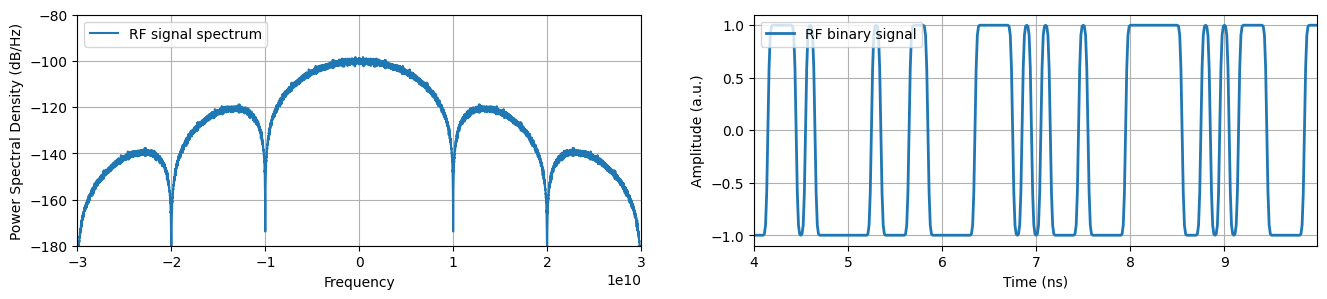

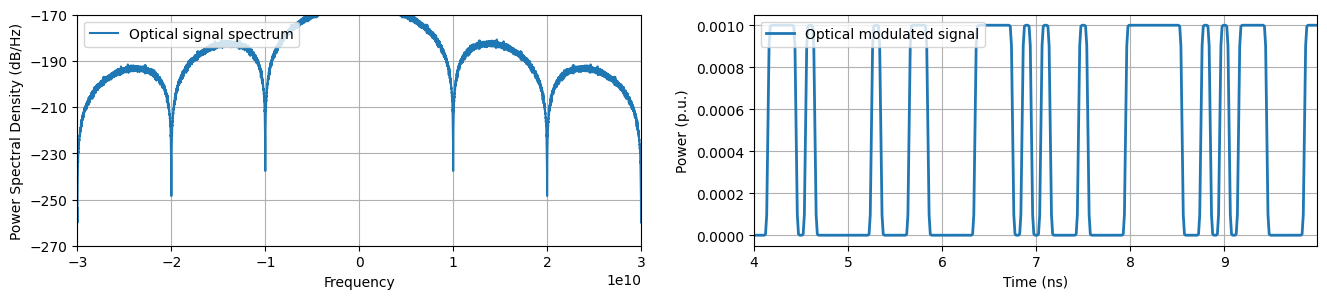

In [9]:
# optical modulation
Ai = np.sqrt(Pi) # Pi: 레이저 광 파워(W): 0dBm→1mW, |E|^2∝Power, Ai=입력 레이저의 광 전기장 진폭
sigTxo = mzm(Ai, sigTx, paramMZM) # sigTxo: 변조된 광 신호(복소 전기장 형태인 경우가 많음)
                                  # 전기파형 sigTx가 MZM를 통해 광 세기(IM)로 반영되어 OOK 광신호가 됨.

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signalPower(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signalPower(sigTxo)/1e-3)))
# signalPower(sigTxo): sigTxo의 평균 파워를 W로 계산, 1e-3: W->mW로 바꿔서 표시
# MZM 통과 후 평균 광파워가 어느 정도 인지 확인

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50) # interval: 파형 일부 구간만 잘라서 보기 위한 인덱스 = np.arange(16*20,16*50) # interval: 파형 일부 구간만 잘라서 보기 위한 인덱스
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');
# sides: 'twosided' = 주파수를 음/양 대칭으로 표시
# NFFT=FFT length, FFT: 시간 신호->주파수 신호로 변환

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()
# 전기 NRZ 신호가 시간에 따라, 어떻게 생겼는 지 확인: 전기 신호 시간 파형
# 시간 영역; NRZ 형태로 0/1이 유지되는 파형
# 주파수 영역: NRZ 특유의 sinc 계열 스펙트럼 형태

fig, axs = plt.subplots(1, 2, figsize=(16,3))

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-270,-170);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');
# P(t)∝∣E(t)|^2: P(t)=광 파워 파형, E(t): 광 전기장

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()
# 광 신호: "광 파워" 기준 스펙트럼 + 시간 파형 플롯

**Attenuate the optical signal**

In [10]:
att = 20 # attenuation in dB
sigTxo = voa(sigTxo, att)

**Without optical amplification**

Direct-detection (DD) pin receiver model

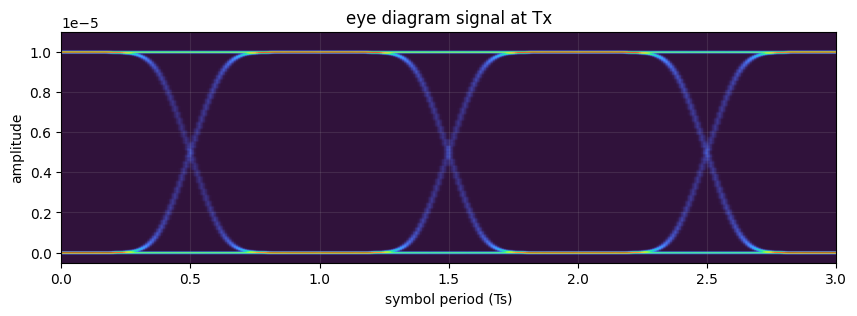

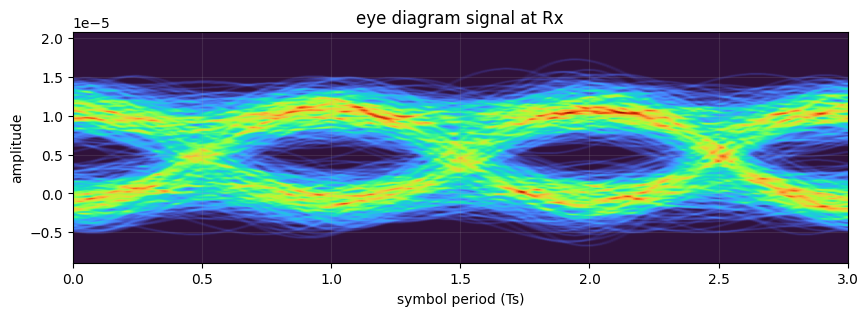

In [11]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)
# ideal=True: 노이즈 0, 대역 제한 0 같은 '이상적인 검출기'
# I_Rx_ideal: 수신 전류, 광 신호 sigTxo의 실수부만 포토 다이오드에 넣고 있음

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
# 현실적인 포토다이오드로 검출
paramPD = parameters()
paramPD.ideal = False # 포토다이오 모델: thermal noise, shot noise, BW limitation을 포함해 출력 신호를 만듭니다.
paramPD.B = Rs # 수신 대역폭: 심볼레이트
paramPD.Fs = Fs # 샘플링 주파수

I_Rx = photodiode(sigTxo.real, paramPD)

discard = 100*SpS

eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

In [12]:
# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0
# bit=0,1일때, 평균 전류/전압

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0
# "0,1" 레벨의 잡음: 눈의 두께

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Eye opening: 최적 샘플링 시점에서 1과 0 사이의 수직 거리
# 수신기가 신호를 읽는 순간, 위쪽 레벨(1)과 아래쪽 레벨(0)이 얼마나 떨어져 있는가를 의미.

I0 = -0.15 
I1 = 2.14 
σ0 = 0.37 
σ1 = 0.37 
Optimal decision threshold Id = 0.99 
Q = 3.10 



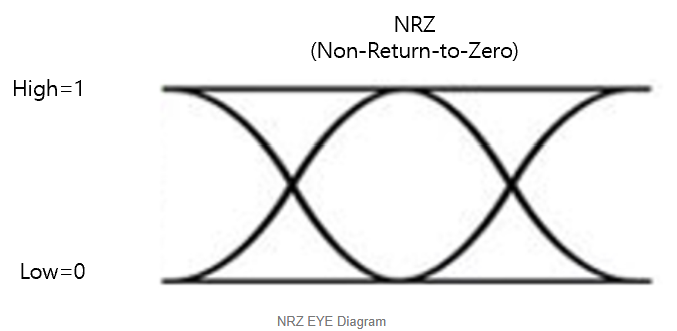

err1값: [False False False ... False False False]
Number of counted errors = 105 
BER = 1.05e-03 
Pb = 9.81e-04 
err2값: [0. 0. 0. ... 0. 0. 0.]


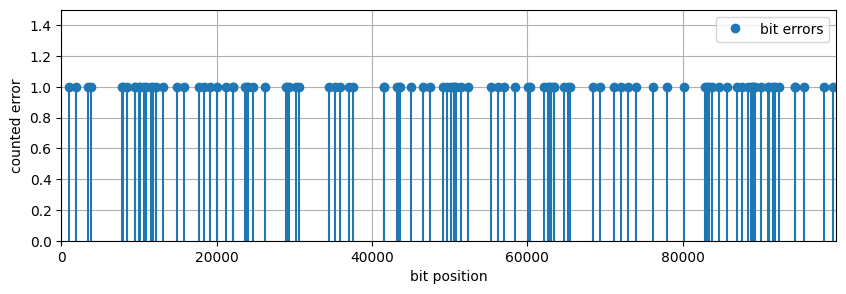

In [13]:
# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
print('err1값:',err)
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
print('err2값:',err)
err[err==0] = np.nan
# err에서 0인 값들을 NaN으로 바꿔서, 계산/그래프에서 제외하는 코드

plt.plot(err,'o', label = 'bit errors') # 에러가 난 bit 위치만 점/세로선으로 표시
# burst error: 에러가 연속해서 발생. 특정 구간에서 몰림.
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

**Optical amplification**

In [14]:
# EDFA parameters
param_edfa = parameters()
# gain control
param_edfa.type     = "AGC"
param_edfa.value    = 20 #dB
# AGC: 입력이 변해도, 증폭기 이득(Gain)을 20dB로 유지하도록 제어

# pid - gain control
param_edfa.kp = 2e-3
param_edfa.ki = 0
param_edfa.kd = 0
# AGC를 구현할 때 쓰는 제어 루프(PID)의 계수

# pump information
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
# backward pump가 0이므로, 단방향 펌핑

# giles parameters
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5
# giles_*.dat: EDFA의 흡수/방출 단면적, 도핑/길이 등이 들어간 모델 파라미터 파일
# tol, tolCtrl: 수치해석/제어 수렴 허용 오차

# ASE
param_edfa.noiseBand= 1.25e9
# ASE를 계산할 때의 참조 잡음 대역폭(Hz)->1.25GHz, 그 대역폭에 해당하는 ASE 파워를 기준으로 noise를 만듦

if 'google.colab' in str(get_ipython()):
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic', 'models', 'ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic', 'models', 'ampParams', param_edfa.file)

Sample rate [THz]: 0.080
Time window [ns]:  10000.000
Central wavelength [nm]: 1550.00
Simulation window  [nm]: 0.641110 - [1549.68 nm - 1550.32 nm]
Frequency spacing [GHz]: 0.000100
Number of points: 800000
Number of modes: 1
Average power - TX [mW] : 0.005 mW
Average power - TX [dBm] : -23.008 dBm


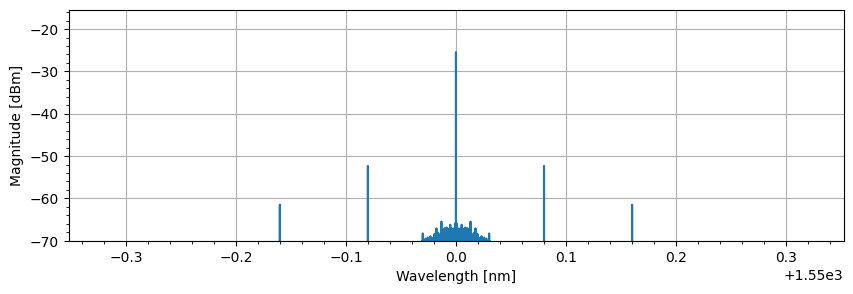

In [15]:
Fc = c/1550e-9 # central wavelength
Nmodes = 1     # number of modes
# 전송 신호가 몇 개의 공간 모드를 사용하는 가->SMF: 하나의 광 경로만 존재

sigTxo = np.reshape(sigTxo, (len(sigTxo), 1))
lenFrqSg, isy = np.shape(sigTxo)
simOpticalBand = (Fs*(c/Fc)**2)/c # 전기 주파수 대역폭->파장 대역폭 변환
tx_pw = np.sum(1000*np.mean(sigTxo * np.conj(sigTxo), axis = 0).real)
# 1000: W→mW, 단위 변환
# sigTxo*np.conj(sigTxo): 순간 광 파워
# simOpticalBand: 송신 신호의 평균 광 파워를 계산하는 코드

# information TX
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*lenFrqSg/Fs)) # 시뮬레이션에서 한 번에 다루는 시간 구간의 길이
print('Central wavelength [nm]: %6.2f' %(1e9*c/Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]'
      %(1e9*simOpticalBand, 1e9*(c/Fc-simOpticalBand/2), 1e9*(c/Fc+simOpticalBand/2)))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/lenFrqSg))
print('Number of points: %d' %(lenFrqSg))
print('Number of modes: %d' %(Nmodes))
print('Average power - TX [mW] : %.3f mW' %(tx_pw))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(tx_pw)))

OSA(sigTxo, Fs, Fc); # 송신 스펙트럼을 OSA처럼 시각화
# EDFA를 통과시키면 ASE가 스펙트럼 바닥을 올려서 OSNR 악화가 눈에 보이게 됨.

**EDFA 모델을 실제 통과시켜서, 출력신호 + 펌프/잡음 관련 내부 결과를 받는 신호**

In [16]:
Eout, PumpF, PumpB, noisef = edfaSM(sigTxo, Fs, Fc, param_edfa)
# Eout: EDFA를 지난 후의 광 신호
# PumpF: Forward pump의 분포/상태
# PumpB: Backward pump의 분포/상태
# noisef: EDFA가 생성하는 ASE noise 관련 결과

INFO:root:
EDF absorption and gain coeficients. Calculating absorption and emission cross-section ...
INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -0.045%.

INFO:root:EDFA SM: control loop  1
INFO:root:Convergence: 11.431 dB
INFO:root:Pump for.: 77.14 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -29.606%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: 0.058%.

INFO:root:EDFA SM: control loop  2
INFO:root:Convergence: 10.967 dB
INFO:root:Pump for.: 55.20 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -39.667%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: 0.098%.

INFO:root:EDFA SM: control loop  3
INFO:root:Convergence: 10.194 dB
INFO:root:Pump for.: 34.81 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -58.431%.

INFO:root:EDFA SM: loop  2
INFO:root:Convergence: 0.138%.

INFO:root:EDFA SM: control loop  4
INFO:root:Convergence: 8.679 dB
INFO:root:Pump for.: 17.46 mW

INFO:root:EDFA SM: loop  1
INFO:root:Convergence: -99.240%.

INFO:root:EDFA SM: loo

Forward pump  - [mW] : 12.983
Backward pump - [mW] : 0.000
Average power - RX amp [mW] : 0.717
Average power - RX amp [dBm] : -1.447
Gain [dB]: 21.561


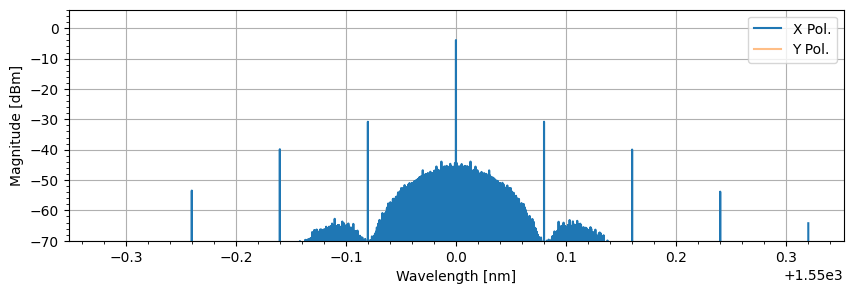

In [17]:
rx_pw = np.sum(1000*np.mean(Eout * np.conj(Eout), axis = 0).real)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/tx_pw)))

OSA(Eout, Fs, Fc);

**광 신호->전기신호 변환 이상적인/현실적인 경우**

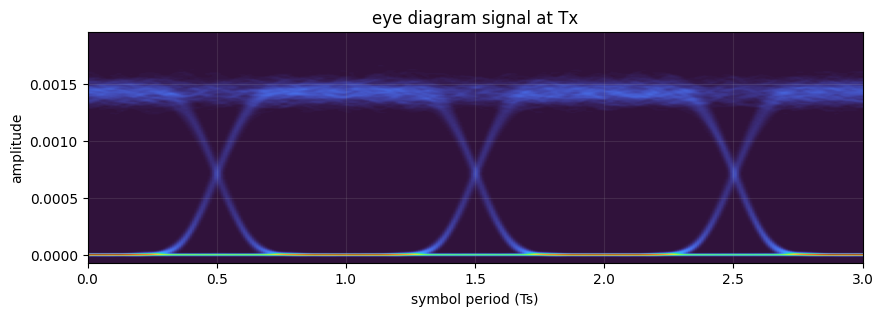

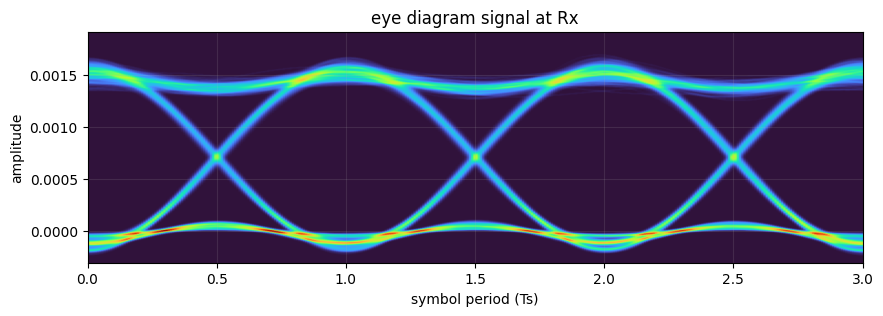

I0 = -0.16 
I1 = 2.29 
σ0 = 0.07 
σ1 = 0.09 
Optimal decision threshold Id = 0.95 
Q = 15.68 



In [18]:
# ideal photodiode (noiseless, no bandwidth limitation): 완벽한 포토 다이오드
paramPD = parameters()
paramPD.ideal = True
I_Rx_Amp_ideal = photodiode(Eout[:,0].real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation): 현실적인 수신기 모델
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs # 포토다이오드 대역폭 : 심볼율->수신기 필터가 신호 속도에 맞게 제한됨
paramPD.Fs = Fs # 시뮬레이션 샘플링 주파수

I_Rx_Amp = photodiode(Eout[:,0].real, paramPD)

discard = 100*SpS

eyediagram(I_Rx_Amp_ideal[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx_Amp[discard:-discard].copy(), I_Rx_Amp.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I_Rx_Amp = I_Rx_Amp/np.std(I_Rx_Amp) # 수신 신호 스케일 정규화

# capture samples in the middle of signaling intervals
I_Rx_Amp = I_Rx_Amp[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx_Amp[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx_Amp[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx_Amp[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx_Amp[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
# 수신기에서 0과 1을 구분하는 최적 판정 임계값(threshold)
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx_Amp> Id] = 1
bitsRx[I_Rx_Amp<= Id] = 0

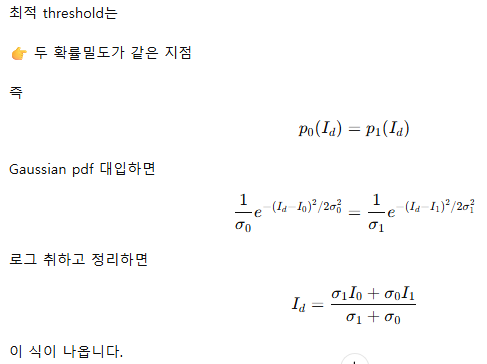

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 1.03e-55 


(0.0, 99800.0)

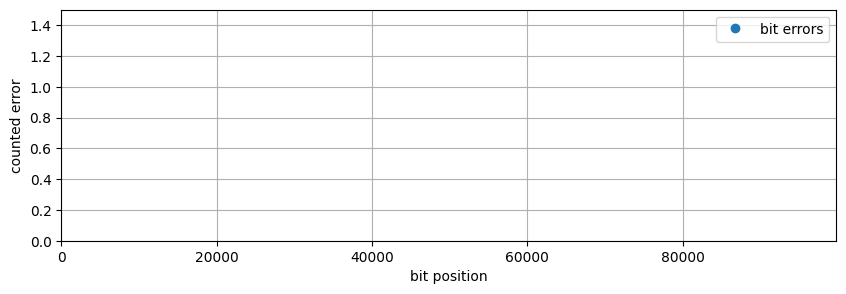

In [19]:
discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size)